In [1]:
%reload_ext autoreload
%autoreload 2

import argparse
import dgym as dg

def get_data(path):

    deck = dg.MoleculeCollection.load(
        f'{path}/DSi-Poised_Library_annotated.sdf',
        reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
    )

    reactions = dg.ReactionCollection.from_json(
        path = f'{path}/All_Rxns_rxn_library.json',
        smarts_col = 'reaction_string',
        classes_col = 'functional_groups'
    )

    building_blocks = dg.datasets.disk_loader(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
    fingerprints = dg.datasets.fingerprints(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

    import torch
    import pyarrow.parquet as pq
    table = pq.read_table(f'{path}/sizes.parquet')[0]
    sizes = torch.tensor(table.to_numpy())

    return deck, reactions, building_blocks, fingerprints, sizes

In [2]:
def get_docking_config(path, target_index):
    
    import os

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    with open(dockstring_dir + configs[target_index], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target_file = targets[target_index]
    target = target_file.split('_')[0]
    
    name = f'{target} affinity'
    receptor_path = f'{path}/dockstring_targets/{target_file}'
    config = {
        'search_mode': 'balanced',
        'scoring': 'gnina',
        'seed': 5,
        'size_x': 15.0,
        'size_y': 15.0,
        'size_z': 15.0,
        **config_
    }
    
    return name, receptor_path, config

In [3]:
def get_utility(path, target_index):

    # Docking oracles
    from dgym.envs.oracle import DockingOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    # Create noiseless evaluators
    name, receptor_path, config = get_docking_config(path, target_index)
    docking_oracle = DockingOracle(name, receptor_path=receptor_path, config=config)
    docking_utility = ClassicUtilityFunction(
        docking_oracle, ideal=(8.5, 11), acceptable=(7.125, 11))
    noisy_docking_utility = ClassicUtilityFunction(
        NoisyOracle(docking_oracle, sigma=0.7), ideal=(8.5, 11), acceptable=(7.125, 11))

    # log P oracle
    log_P_oracle = RDKitOracle('MolLogP')
    log_P_utility = ClassicUtilityFunction(
        log_P_oracle, ideal=(1, 4), acceptable=(-0.5, 5.5))
    noisy_log_P_utility = ClassicUtilityFunction(
        NoisyOracle(log_P_oracle, sigma=1.0), ideal=(1, 4), acceptable=(-0.5, 5.5))

    # create composite utility
    def composite_utility(molecules):
        return (log_P_utility(molecules)**0.4) * (docking_utility(molecules)**0.6)
    def noisy_composite_utility(molecules):
        return (noisy_log_P_utility(molecules)**0.4) * (noisy_docking_utility(molecules)**0.6)

    return log_P_oracle, docking_oracle, composite_utility, noisy_composite_utility

In [4]:
def get_drug_env(
        deck,
        reactions,
        building_blocks,
        fingerprints,
        sizes,
        assays,
        composite_utility
    ):
    
    import pandas as pd
    from dgym.molecule import Molecule
    from dgym.envs.designer import Designer, Generator
    from dgym.envs.drug_env import DrugEnv

    designer = Designer(
        Generator(building_blocks, fingerprints, sizes),
        reactions,
        cache = True
    )

    # select first molecule
    import random
    def select_molecule(deck):
        initial_index = random.randint(0, len(deck) - 1)
        initial_molecule = deck[initial_index]
        if len(initial_molecule.reactants) == 2 \
            and designer.match_reactions(initial_molecule):
            return initial_molecule
        else:
            return select_molecule(deck)

    initial_molecules = [select_molecule(deck) for _ in range(5)]
    initial_library = dg.MoleculeCollection(initial_molecules) # 659
    initial_library.update_annotations()

    drug_env = DrugEnv(
        designer,
        library = initial_library,
        assays = assays,
        budget = 500,
        utility_function = composite_utility,
    )

    return drug_env

Make environment.

In [5]:
from dgym.experiment import Experiment
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

import pandas as pd
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv

# Load all data
path = '../../dgym-data'
args = {'target_index': 0, 'out_dir': './test'}

(
    deck,
    reactions,
    building_blocks,
    fingerprints,
    sizes
) = get_data(path)

(
    *assays,
    composite_utility,
    noisy_composite_utility
) = get_utility(path, args['target_index'])

# Get environment
drug_env = get_drug_env(
    deck,
    reactions,
    building_blocks,
    fingerprints,
    sizes,
    assays=assays,
    composite_utility=composite_utility
)

Make agent.

In [6]:
sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': True}},
    {'name': assays[0].name},
    {'name': assays[1].name},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = noisy_composite_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 1
)

In [13]:
import uuid

experiment = Experiment(drug_agent, drug_env)

target_index = args['target_index']
file_path = f'test/selection_targets_{target_index}_{uuid.uuid4()}.json'
result = experiment.run(**args, out=file_path)

Visualize

In [27]:
import math
import numpy as np
import igraph as ig

graph_scores = []
adjacency_tuples = []
for molecule in drug_env.library:
    if molecule.inspiration \
        and molecule.inspiration != molecule:
        adjacency_tuple = (molecule.inspiration.name, molecule.name)
        adjacency_tuples.append(adjacency_tuple)
    # else:
    #     adjacency_tuple = ('parent', molecule.name)
    #     adjacency_tuples.append(adjacency_tuple)

g = ig.Graph.TupleList(set(adjacency_tuples), directed=True)

In [28]:
import seaborn as sns

palette = sns.color_palette("magma", as_cmap=True)

def normalize_array(arr):
    """
    Normalize a numpy array to have its minimum and maximum values scaled to 0 and 1, respectively.
    
    Parameters
    ----------
    arr : np.ndarray
        The input array to normalize.
    
    Returns
    -------
    np.ndarray
        The normalized array with values scaled between 0 and 1.
    
    Example
    -------
    >>> arr = np.array([10, 20, 30, 40, 50])
    >>> normalize_array(arr)
    array([0. , 0.25, 0.5 , 0.75, 1. ])
    """
    arr = np.array(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

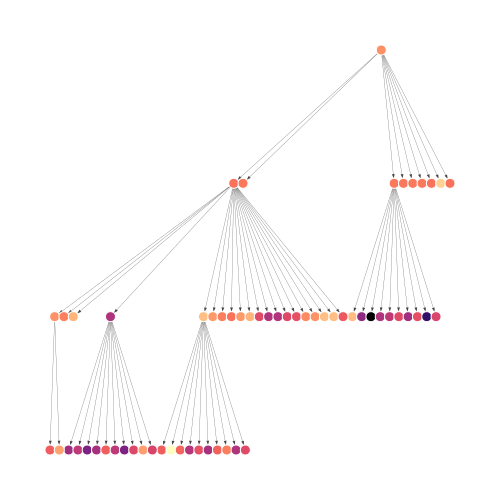

In [29]:
scores = assays[0]([
    dg.molecule.Molecule(v)
    for v in g.get_vertex_dataframe()['name']
    if v != 'parent'
])

layout = g.layout("rt")

ig.plot(
    g,
    layout=layout,
    bbox=(500, 500),
    vertex_color=palette(normalize_array(scores)).tolist(),
    vertex_frame_color='white',
    edge_width=0.25,
    colorbar=palette,
    edge_arrow_size=0.3,
    margin=50,
    vertex_size=10,
)

Properties

<function rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms>

In [36]:
from rdkit.Chem import rdMolDescriptors, Lipinski

descriptors = [
    'NumHeavyAtoms',
    'FractionCSP3',
    'NumAtomStereoCenters',
    'NumRotatableBonds',
    'TPSA',
    'NumRings',
    'NumAliphaticRings',
    'NumAromaticRings',
    '
]

struct_descriptor = getattr(rdMolDescriptors, 'CalcNumHeavyAtoms')
num_heavy_atoms = [
    rdMolDescriptors.CalcNumHeavyAtoms(m.mol)
    for m in drug_env.library
]

frac_csp3 = [
    rdMolDescriptors
]

<Axes: >

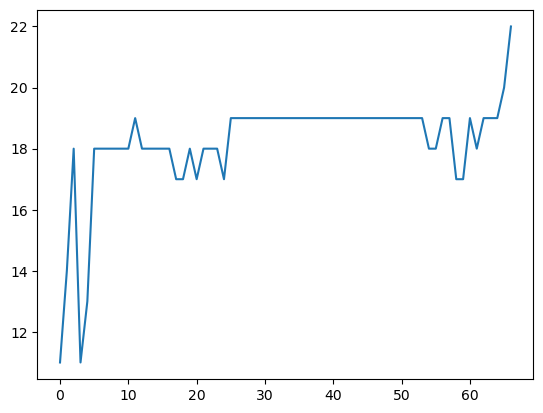

In [40]:
import seaborn as sns

sns.lineplot(num_heavy_atoms)